Tasa de Error de Bit (BER) para ASK: 0.5013
Tasa de Error de Bit (BER) para FSK: 0.4983
Tasa de Error de Bit (BER) para BPSK: 0.5043
Tasa de Error de Bit (BER) para QPSK: 0.4988
Tasa de Error de Bit (BER) para 8-PSK: 0.4955495549554956
Tasa de Error de Bit (BER) para 16-QAM: 0.4913


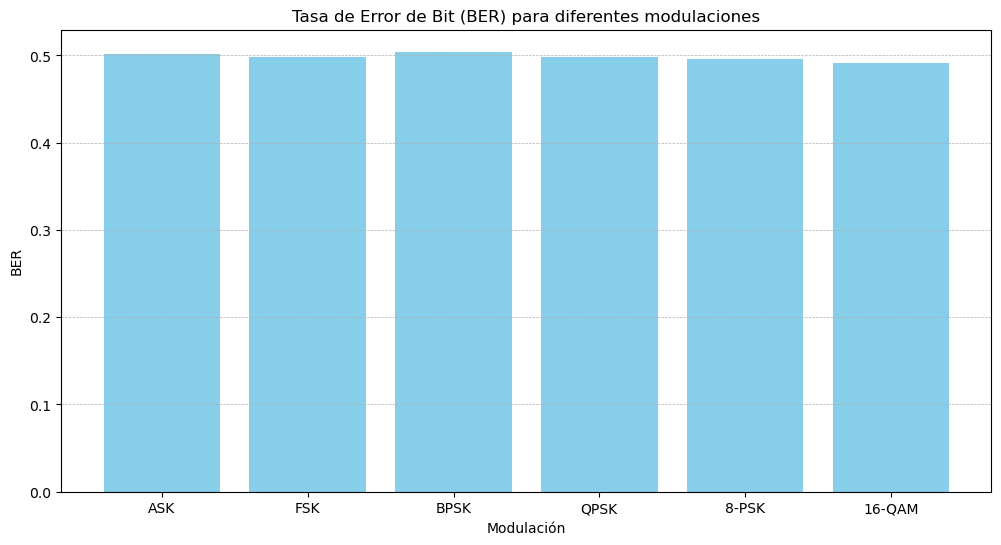

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

# Parámetros generales
N = 10000      # Número de bits
fs = 100000    # Frecuencia de muestreo
Tb = 1e-3      # Duración de cada bit
fc = 5000      # Frecuencia de la portadora
Eb_N0_dB = 10  # Relación Eb/N0 en decibelios

# Impedimentos del canal
atenuacion = 0.8            # Atenuación del canal
ancho_banda = 4000          # Limitación de frecuencia en Hz

# Desfasaje en el receptor (simula diferencia de fase)
desfase_receptor = np.pi / 4  # Desfasaje en radianes en el oscilador local

# Generación de bits aleatorios
def generar_bits(N):
    return np.random.randint(0, 2, N)

# Función de canal con impedimentos
def canal(señal, fs, atenuacion, ancho_banda):
    # Aplicar atenuación
    señal = atenuacion * señal
    # Limitación de frecuencia (filtro pasa banda)
    nyq = fs / 2
    low = (fc - ancho_banda / 2) / nyq
    high = (fc + ancho_banda / 2) / nyq
    # Asegurar que low > 0 y high < 1
    if low <= 0:
        low = 0.0001
    if high >= 1:
        high = 0.9999
    b, a = butter(5, [low, high], btype='band')
    señal_filtrada = lfilter(b, a, señal)
    return señal_filtrada

# Añadir ruido AWGN
def añadir_ruido(señal, Eb_N0_dB, fs, Tb):
    Eb_N0 = 10 ** (Eb_N0_dB / 10)
    potencia_señal = np.mean(señal ** 2)
    N0 = potencia_señal / Eb_N0
    ruido = np.sqrt(N0 * fs / (2 * Tb)) * np.random.randn(len(señal))
    señal_ruidosa = señal + ruido
    return señal_ruidosa

# Calcular Tasa de Error de Bit (BER)
def calcular_ber(bits_originales, bits_recuperados):
    errores = np.sum(bits_originales != bits_recuperados)
    ber = errores / len(bits_originales)
    return ber

# Modulador ASK
def modulador_ask(bits, fc, fs, Tb):
    Ns = int(Tb * fs)
    t = np.arange(0, len(bits) * Tb, 1 / fs)
    bits_upsampled = np.repeat(bits, Ns)
    señal_modulada = bits_upsampled * np.cos(2 * np.pi * fc * t)
    return señal_modulada, t

# Demodulador ASK no coherente
def demodulador_ask_no_coherente(señal_recibida, Ns, N):
    bits_recuperados = []
    for i in range(N):
        muestra = señal_recibida[i * Ns:(i + 1) * Ns]
        energia = np.sum(muestra ** 2)
        bits_recuperados.append(1 if energia > 0.5 else 0)
    return np.array(bits_recuperados)

# Modulador FSK
def modulador_fsk(bits, f0, f1, fs, Tb):
    Ns = int(Tb * fs)
    t = np.arange(0, len(bits) * Tb, 1 / fs)
    señal_modulada = np.zeros(len(t))
    for i in range(len(bits)):
        fi = f1 if bits[i] == 1 else f0
        señal_modulada[i * Ns:(i + 1) * Ns] = np.cos(2 * np.pi * fi * t[i * Ns:(i + 1) * Ns])
    return señal_modulada, t

# Demodulador FSK no coherente
def demodulador_fsk_no_coherente(señal_recibida, f0, f1, fs, Tb, N):
    Ns = int(Tb * fs)
    bits_recuperados = []
    t = np.arange(0, Tb, 1 / fs)
    cos_f0 = np.cos(2 * np.pi * f0 * t)
    cos_f1 = np.cos(2 * np.pi * f1 * t)
    for i in range(N):
        muestra = señal_recibida[i * Ns:(i + 1) * Ns]
        correlacion_f0 = np.sum(muestra * cos_f0)
        correlacion_f1 = np.sum(muestra * cos_f1)
        bits_recuperados.append(1 if correlacion_f1 > correlacion_f0 else 0)
    return np.array(bits_recuperados)

# Modulador BPSK
def modulador_bpsk(bits, fc, fs, Tb):
    Ns = int(Tb * fs)
    t = np.arange(0, len(bits) * Tb, 1 / fs)
    bits_upsampled = np.repeat(bits * 2 - 1, Ns)
    señal_modulada = bits_upsampled * np.cos(2 * np.pi * fc * t)
    return señal_modulada, t

# Demodulador BPSK
def demodulador_bpsk(señal_recibida, fc, fs, Tb, N, desfase_receptor):
    Ns = int(Tb * fs)
    t = np.arange(0, N * Tb, 1 / fs)
    portadora_local = np.cos(2 * np.pi * fc * t + desfase_receptor)
    señal_demodulada = señal_recibida * portadora_local
    bits_recuperados = []
    for i in range(N):
        muestra = señal_demodulada[i * Ns:(i + 1) * Ns]
        suma = np.sum(muestra)
        bits_recuperados.append(1 if suma > 0 else 0)
    return np.array(bits_recuperados)

# Modulador QPSK
def modulador_qpsk(bits, fc, fs, Tb):
    Ns = int(Tb * fs)
    bits = bits[:len(bits) - len(bits) % 2]  # Asegurar que el número de bits es par
    bits_I = bits[0::2]
    bits_Q = bits[1::2]
    t = np.arange(0, len(bits_I) * Tb, 1 / fs)
    bits_I_upsampled = np.repeat(2 * bits_I - 1, Ns)
    bits_Q_upsampled = np.repeat(2 * bits_Q - 1, Ns)
    señal_modulada = bits_I_upsampled * np.cos(2 * np.pi * fc * t) - bits_Q_upsampled * np.sin(2 * np.pi * fc * t)
    return señal_modulada, t

# Demodulador QPSK
def demodulador_qpsk(señal_recibida, fc, fs, Tb, N, desfase_receptor):
    Ns = int(Tb * fs)
    N = N - N % 2  # Asegurar que N es par
    t = np.arange(0, (N // 2) * Tb, 1 / fs)
    portadora_I = np.cos(2 * np.pi * fc * t + desfase_receptor)
    portadora_Q = -np.sin(2 * np.pi * fc * t + desfase_receptor)
    señal_I = señal_recibida * portadora_I
    señal_Q = señal_recibida * portadora_Q
    bits_recuperados = []
    for i in range(N // 2):
        muestra_I = señal_I[i * Ns:(i + 1) * Ns]
        muestra_Q = señal_Q[i * Ns:(i + 1) * Ns]
        suma_I = np.sum(muestra_I)
        suma_Q = np.sum(muestra_Q)
        bits_recuperados.append(1 if suma_I > 0 else 0)
        bits_recuperados.append(1 if suma_Q > 0 else 0)
    return np.array(bits_recuperados)

# Modulador 8-PSK
def modulador_8psk(bits, fc, fs, Tb):
    Ns = int(Tb * fs)
    M = 8
    bits_por_simbolo = 3
    num_simbolos = len(bits) // bits_por_simbolo
    bits = bits[:num_simbolos * bits_por_simbolo]
    simbolos = bits.reshape((num_simbolos, bits_por_simbolo))
    t = np.arange(0, num_simbolos * Tb, 1 / fs)
    fases = np.dot(simbolos, 2 ** np.arange(bits_por_simbolo)[::-1]) * (2 * np.pi / M)
    fases_upsampled = np.repeat(fases, Ns)
    señal_modulada = np.cos(2 * np.pi * fc * t + fases_upsampled)
    return señal_modulada, t

# Demodulador 8-PSK
def demodulador_8psk(señal_recibida, fc, fs, Tb, N, desfase_receptor):
    Ns = int(Tb * fs)
    M = 8
    bits_por_simbolo = 3
    num_simbolos = len(señal_recibida) // Ns
    bits_recuperados = []
    t = np.arange(0, num_simbolos * Tb, 1 / fs)
    for i in range(num_simbolos):
        muestra = señal_recibida[i * Ns:(i + 1) * Ns]
        t_muestra = t[i * Ns:(i + 1) * Ns]
        referencia = np.exp(-1j * (2 * np.pi * fc * t_muestra + desfase_receptor))
        suma = np.sum(muestra * referencia)
        fase_estimada = np.angle(suma)
        simbolo_est = int(np.round(fase_estimada * M / (2 * np.pi))) % M
        bits_simbolo = [int(x) for x in np.binary_repr(simbolo_est, width=bits_por_simbolo)]
        bits_recuperados.extend(bits_simbolo)
    return np.array(bits_recuperados[:N])

# Modulador 16-QAM
def modulador_16qam(bits, fc, fs, Tb):
    Ns = int(Tb * fs)
    M = 16
    bits_por_simbolo = 4
    num_simbolos = len(bits) // bits_por_simbolo
    bits = bits[:num_simbolos * bits_por_simbolo]
    simbolos = bits.reshape((num_simbolos, bits_por_simbolo))
    t = np.arange(0, num_simbolos * Tb, 1 / fs)
    I = (2 * simbolos[:, :2].dot(2 ** np.array([1, 0])) - 3)
    Q = (2 * simbolos[:, 2:].dot(2 ** np.array([1, 0])) - 3)
    I_upsampled = np.repeat(I, Ns)
    Q_upsampled = np.repeat(Q, Ns)
    señal_modulada = I_upsampled * np.cos(2 * np.pi * fc * t) - Q_upsampled * np.sin(2 * np.pi * fc * t)
    return señal_modulada, t

# Demodulador 16-QAM
def demodulador_16qam(señal_recibida, fc, fs, Tb, N, desfase_receptor):
    Ns = int(Tb * fs)
    M = 16
    bits_por_simbolo = 4
    num_simbolos = len(señal_recibida) // Ns
    bits_recuperados = []
    t = np.arange(0, num_simbolos * Tb, 1 / fs)
    portadora_I = np.cos(2 * np.pi * fc * t + desfase_receptor)
    portadora_Q = -np.sin(2 * np.pi * fc * t + desfase_receptor)
    señal_I = señal_recibida * portadora_I
    señal_Q = señal_recibida * portadora_Q
    for i in range(num_simbolos):
        muestra_I = señal_I[i * Ns:(i + 1) * Ns]
        muestra_Q = señal_Q[i * Ns:(i + 1) * Ns]
        promedio_I = np.sum(muestra_I) / Ns
        promedio_Q = np.sum(muestra_Q) / Ns
        nivel_I = np.round((promedio_I + 3) / 2).astype(int)
        nivel_Q = np.round((promedio_Q + 3) / 2).astype(int)
        nivel_I = np.clip(nivel_I, 0, 3)
        nivel_Q = np.clip(nivel_Q, 0, 3)
        bits_I = [int(x) for x in np.binary_repr(nivel_I, width=2)]
        bits_Q = [int(x) for x in np.binary_repr(nivel_Q, width=2)]
        bits_recuperados.extend(bits_I + bits_Q)
    return np.array(bits_recuperados[:N])

# Simulación para diferentes modulaciones
modulaciones = ['ASK', 'FSK', 'BPSK', 'QPSK', '8-PSK', '16-QAM']
bers = []

for modulacion in modulaciones:
    bits = generar_bits(N)
    Ns = int(Tb * fs)
    if modulacion == 'ASK':
        señal_modulada, t = modulador_ask(bits, fc, fs, Tb)
        señal_canal = canal(señal_modulada, fs, atenuacion, ancho_banda)
        señal_recibida = añadir_ruido(señal_canal, Eb_N0_dB, fs, Tb)
        bits_recuperados = demodulador_ask_no_coherente(señal_recibida, Ns, N)
    elif modulacion == 'FSK':
        f0 = fc - 500
        f1 = fc + 500
        señal_modulada, t = modulador_fsk(bits, f0, f1, fs, Tb)
        señal_canal = canal(señal_modulada, fs, atenuacion, ancho_banda)
        señal_recibida = añadir_ruido(señal_canal, Eb_N0_dB, fs, Tb)
        bits_recuperados = demodulador_fsk_no_coherente(señal_recibida, f0, f1, fs, Tb, N)
    elif modulacion == 'BPSK':
        señal_modulada, t = modulador_bpsk(bits, fc, fs, Tb)
        señal_canal = canal(señal_modulada, fs, atenuacion, ancho_banda)
        señal_recibida = añadir_ruido(señal_canal, Eb_N0_dB, fs, Tb)
        bits_recuperados = demodulador_bpsk(señal_recibida, fc, fs, Tb, N, desfase_receptor)
    elif modulacion == 'QPSK':
        bits = bits[:len(bits) - len(bits) % 2]  # Asegurar que el número de bits es par
        señal_modulada, t = modulador_qpsk(bits, fc, fs, Tb)
        señal_canal = canal(señal_modulada, fs, atenuacion, ancho_banda)
        señal_recibida = añadir_ruido(señal_canal, Eb_N0_dB, fs, Tb)
        bits_recuperados = demodulador_qpsk(señal_recibida, fc, fs, Tb, len(bits), desfase_receptor)
    elif modulacion == '8-PSK':
        bits_por_simbolo = 3
        bits = bits[:len(bits) - len(bits) % bits_por_simbolo]
        señal_modulada, t = modulador_8psk(bits, fc, fs, Tb)
        señal_canal = canal(señal_modulada, fs, atenuacion, ancho_banda)
        señal_recibida = añadir_ruido(señal_canal, Eb_N0_dB, fs, Tb)
        bits_recuperados = demodulador_8psk(señal_recibida, fc, fs, Tb, len(bits), desfase_receptor)
    elif modulacion == '16-QAM':
        bits_por_simbolo = 4
        bits = bits[:len(bits) - len(bits) % bits_por_simbolo]
        señal_modulada, t = modulador_16qam(bits, fc, fs, Tb)
        señal_canal = canal(señal_modulada, fs, atenuacion, ancho_banda)
        señal_recibida = añadir_ruido(señal_canal, Eb_N0_dB, fs, Tb)
        bits_recuperados = demodulador_16qam(señal_recibida, fc, fs, Tb, len(bits), desfase_receptor)
    ber = calcular_ber(bits, bits_recuperados)
    bers.append(ber)
    print(f"Tasa de Error de Bit (BER) para {modulacion}: {ber}")

# Gráfica de BER para diferentes modulaciones
plt.figure(figsize=(12, 6))
plt.bar(modulaciones, bers, color='skyblue')
plt.title('Tasa de Error de Bit (BER) para diferentes modulaciones')
plt.xlabel('Modulación')
plt.ylabel('BER')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de la simulación
N = 10000          # Número de bits
Rb = 1000          # Tasa de bits (bits por segundo)
fs = 10 * Rb       # Frecuencia de muestreo
Tb = 1 / Rb        # Tiempo por bit
fc = 5000          # Frecuencia de la portadora
t = np.arange(0, N*Tb, 1/fs)  # Vector de tiempo

# Generación de bits aleatorios
bits = np.random.randint(0, 2, N)

# Modulador BPSK
def modulador_bpsk(bits, fc, fs, Tb):
    N = len(bits)
    t = np.arange(0, N*Tb, 1/fs)
    # Mapear bits 0->-1 y 1->1
    simbolos = 2*bits - 1
    # Señal modulada
    s = simbolos.repeat(int(fs*Tb)) * np.cos(2*np.pi*fc*t)
    return s

# Canal con impedimentos
def canal(senal_tx, SNR_dB, fs, atenuacion, desfase_frec, desfase_fase):
    # Atenuación
    senal_rx = atenuacion * senal_tx
    # Desplazamiento de frecuencia y fase
    t = np.arange(len(senal_rx)) / fs
    senal_rx *= np.cos(2*np.pi*desfase_frec*t + desfase_fase)
    # Añadir ruido AWGN
    Potencia_senal = np.mean(senal_rx**2)
    Potencia_ruido = Potencia_senal / (10**(SNR_dB/10))
    ruido = np.sqrt(Potencia_ruido) * np.random.randn(len(senal_rx))
    senal_rx += ruido
    return senal_rx

# Demodulador BPSK
def demodulador_bpsk(senal_rx, fc, fs, Tb):
    t = np.arange(0, len(senal_rx)/fs, 1/fs)
    # Señal demodulada coherentemente
    senal_demodulada = senal_rx * np.cos(2*np.pi*fc*t)
    # Integración y decisión
    Ns = int(fs*Tb)
    bits_recuperados = []
    for i in range(0, len(senal_demodulada), Ns):
        muestra = senal_demodulada[i:i+Ns]
        integracion = np.sum(muestra)
        bits_recuperados.append(1 if integracion > 0 else 0)
    return np.array(bits_recuperados)

# Evaluación del BER
def calcular_ber(bits_tx, bits_rx):
    errores = np.sum(bits_tx != bits_rx)
    ber = errores / len(bits_tx)
    return ber

# Parámetros del canal
SNR_dB = 10               # Relación señal a ruido en dB
atenuacion = 0.8          # Atenuación
desfase_frec = 50         # Desfase de frecuencia (Hz)
desfase_fase = np.pi/8    # Desfase de fase (radianes)

# Simulación
senal_tx = modulador_bpsk(bits, fc, fs, Tb)
senal_rx = canal(senal_tx, SNR_dB, fs, atenuacion, desfase_frec, desfase_fase)
bits_rx = demodulador_bpsk(senal_rx, fc, fs, Tb)
ber = calcular_ber(bits, bits_rx)

print(f"BER para BPSK: {ber}")


BER para BPSK: 0.4997


In [11]:
# Modulador QPSK
def modulador_qpsk(bits, fc, fs, Tb):
    N = len(bits)
    t = np.arange(0, N*Tb/2, 1/fs)
    # Asegurar que el número de bits es par
    if N % 2 != 0:
        bits = np.append(bits, 0)
    # Separar bits en componentes I y Q
    bits_I = bits[0::2]
    bits_Q = bits[1::2]
    simbolos_I = 2*bits_I - 1
    simbolos_Q = 2*bits_Q - 1
    # Señal modulada
    s = (simbolos_I.repeat(int(fs*Tb)) * np.cos(2*np.pi*fc*t) -
         simbolos_Q.repeat(int(fs*Tb)) * np.sin(2*np.pi*fc*t))
    return s

# Demodulador QPSK
def demodulador_qpsk(senal_rx, fc, fs, Tb):
    t = np.arange(0, len(senal_rx)/fs, 1/fs)
    # Señales en cuadratura
    senal_I = senal_rx * np.cos(2*np.pi*fc*t)
    senal_Q = -senal_rx * np.sin(2*np.pi*fc*t)
    # Integración y decisión
    Ns = int(fs*Tb)
    bits_recuperados = []
    for i in range(0, len(senal_I), Ns):
        muestra_I = senal_I[i:i+Ns]
        muestra_Q = senal_Q[i:i+Ns]
        integracion_I = np.sum(muestra_I)
        integracion_Q = np.sum(muestra_Q)
        bits_recuperados.append(1 if integracion_I > 0 else 0)
        bits_recuperados.append(1 if integracion_Q > 0 else 0)
    return np.array(bits_recuperados[:len(bits)])

# Simulación
senal_tx = modulador_qpsk(bits, fc, fs, Tb)
senal_rx = canal(senal_tx, SNR_dB, fs, atenuacion, desfase_frec, desfase_fase)
bits_rx = demodulador_qpsk(senal_rx, fc, fs, Tb)
ber = calcular_ber(bits, bits_rx)

print(f"BER para QPSK: {ber}")


BER para QPSK: 0.4932
